# How to use reconstruction toolbox:

**To use the reconstruction toolbox:**  

**1.)** Download the repository to a local directory.  
**2.)** In this file, scroll to the "User Inputs" section and look at the "FILEPATH SETUP" section.  
**3.)** Fill in the sms_folder and raki_recon_folder with the "data" and "model_folder" filepaths, respectively.  
**4.)** In the "GPU ACCELERATION" section, input your PyTorch device of choice, GPU is highly recommended.  
**5.)** Look through the other values within the "USER INPUT" section and adjust as desired.  
**6.)** Select "Run All" in the notebook.  

**To apply the reconstructions to your own data in this notebook:**  

**1.)** Save your calibration (POMP) data and accelerated (blipped-CAIPI) kspace data as h5 files in a folder titled "SMS_N", where N is equal to the SMS factor. Partial POMP should work with this code, given that the num_calib_lines or in_plane_acs_sizes do not exceed that of the collected lines. This code currently does not work for multiple collections of SMS factors, so only one kspace dataset per SMS factor will work.  
**2.)** If multiple SMS factors are collected, they will need to be in the same folder. This folder's filepath should be set to the "sms_folder" variable.  
**3.)** Go through the "USER INPUT" section and tweak any reconstruction parameters as desired. 

**Otherwise:**  

You can just look at the function calls in the "Image Reconstruction" section of this notebook and look at the functions themselves in the MultibandMRI repository to apply or tweak the code based on your specifications and needs. At the bare minimum, you can call the functions like so:

\# Call the class (automatically does the calibration)  
obj = slice_grappa(calibration_data) \# Replace with any function of your choice  

\# Apply the grappa by calling the apply function  
kspace, _ = slice_grappa.apply(accelerated_data)  

We encourage you to look at the functions themselves to see what parameters you can pass into the functions. All possible parameters that can be passed into the functions are done so as a part of this reconstruction notebook.

# Install MultibandMRI module

In [1]:
!pip3 uninstall -y MultibandMRI 
!pip3 install git+https://github.com/AdaptiveMRILab/MultibandMRI.git@bspline
# !pip3 install git+https://github.com/AdaptiveMRILab/MultibandMRI.git

Found existing installation: MultibandMRI 0.1.0
Uninstalling MultibandMRI-0.1.0:
  Successfully uninstalled MultibandMRI-0.1.0
  Cloning https://github.com/AdaptiveMRILab/MultibandMRI.git (to revision bspline) to /private/var/folders/wq/cc2730014qb_xh3x7s2r89t80000gs/T/pip-req-build-cgy3tdjk
  Running command git clone --filter=blob:none --quiet https://github.com/AdaptiveMRILab/MultibandMRI.git /private/var/folders/wq/cc2730014qb_xh3x7s2r89t80000gs/T/pip-req-build-cgy3tdjk
  Running command git checkout -b bspline --track origin/bspline
  Switched to a new branch 'bspline'
  branch 'bspline' set up to track 'origin/bspline'.
  Resolved https://github.com/AdaptiveMRILab/MultibandMRI.git to commit 670638662201c8402a48a1b16763e11bf95b06b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for MultibandMRI: filename=multibandmri-0.1.0-py3-none-any.whl size=18447 sha256=87c9e580b53a90393ea06

# Imports

In [2]:
import h5py 
import numpy as np 
import torch 
import os
import matplotlib.pyplot as plt
from MultibandMRI import slice_grappa, split_slice_grappa, sense_grappa, slice_raki, split_slice_raki, sense_raki, ifft2d, fft2d, CoilCompress

# User Inputs

In [ ]:
################################
#       GPU ACCELERATION       #
################################

# "device" will be where the compuations will take place, this may change depending on your device
device = torch.device('cpu')
# device = torch.device('cuda:0')

################################
#        FILE PATH SETUP       #
################################

# The filepath that contains the SMS data
# String should be along the lines of: "/{filepath-to-repository}/multiband_mri/data"
sms_folder = '/Users/ty12125/research/Adaptive_MRI_Repositories/multiband_mri/data'
# sms_folder = '/{filepath-to-repository}/multiband_mri/data'

# The path that contains RAKI models
# String should be along the lines of: "/{filepath-to-repository}/multiband_mri/model_folder"
raki_recon_folder = '/Users/ty12125/research/Adaptive_MRI_Repositories/multiband_mri/model_folder'
# raki_recon_folder = '/{filepath-to-repository}/multiband_mri/model_folder'

################################
#       COIL COMPRESSION       #
################################

# A flag that will determine whether or not coil compression occurs
# Possible options: True / False
coil_compression = True

# The number of coils after compression
# Accepted values = Integers less than 32
ncoils = 16

################################
#     RECONSTRUCTION TYPES     #
################################

# A list of all SMS factors to be reconstructed
# Accepted values = [2, 3, 4, 5]
sms_factors = [2]
# sms_factors = [2, 3, 4, 5]

# A list of all GRAPPA recon types to complete
# Can be empty, will only perform RAKI if that is the case
# Possible options: 'slice-grappa', 'split-slice-grappa', 'sense-grappa'
grappa_recon_types = ['slice-grappa']
# grappa_recon_types = ['slice-grappa', 'split-slice-grappa', 'sense-grappa']

# A list of all RAKI recon types to complete
# Can be empty, will only perform GRAPPA if that is the case
# Possible options: 'slice-grappa', 'split-slice-grappa', 'sense-grappa'
raki_recon_types = ['slice-raki']
# raki_recon_types = ['slice-raki', 'split-slice-raki', 'sense-raki']

################################
#   RECONSTRUCTION PARAMETERS  #
################################

# List of number of calibration lines used to calculate kernels
# Accepted values: Positive integer values less than 256
num_calib_lines = [48]

# List of all retrospective in-plane acceleration factors 
# Accepted values: Positive, non-zero integers
in_plane_acceleration_factors = [2]
# in_plane_acceleration_factors = [1, 2]

# Number of ACS lines used in accelerated datasets (retrospective)
# Can be a list, but recommended to be a singular value
# Note: The code will utilize significantly more GPU resources if there are multiple values in the list
# Accepted values: Positive integer value less than 256
in_plane_acs_sizes = [0]

# List of all readout kernel sizes to try 
# Accepted values: Odd values (will become even if appropriate (i.e. SENSE-GRAPPA))
readout_kernel_size = [5]

# List of phase kernel sizes 
# Accepted values: Odd values (will become even if appropriate)
phase_kernel_size = [5] 

################################
#       GRAPPA PARAMETERS      #
################################

# List of tikhonov regularization parameters
# Accepted values: Greater than or equal to zero
tik_values = [0.0]

################################
#        RAKI PARAMETERS       #
################################

# List of network types 'MLP' or 'RES' 
# 'MLP' - complex-valued fully connected multi-layer network
# 'RES' - complex-valued residual network with fully connected layers
#         (if 'RES' is selected, num_layers will be the number of residual blocks,
#          which themselves each have three fully-connected layers)
net_types = ['MLPb']
# net_types = ['MLP']

# List of number of layers to use 
# Accepted values: Positive ingeters
num_layers = [3]

# List of number of nuerons per hidden layer in the CNN
# Accepted values: Positive ingeters
hidden_sizes = [128]

# List of the number of epochs to try
# Accepted values: Positive ingeters
num_epochs = [500]

# List of training/validation data splits
# Accepted values: Between zero and one, excluding zero and one
train_splits = [0.9]

# Flexible tradeoff between zero (no residual RAKI) and one (residual RAKI)
# Instead of learning residual flags, this allows a more flexible tradeoff 
#   between linear reconstruction and RAKI reconstruction
# Accepted values: Between zero and one, including zero and one
linear_weights = [0.0]

# List of L1/L2 loss tradeoff values
# Accepted values: Between zero and one, including zero and one
# 0.0 = L1 loss
# 1.0 = L2 loss
# 0.0 < value < 1.0 is a weighted sum of L1 and L2
l1_l2_tradeoff_values = [0.0]

# Load in Data and Show Reference Images

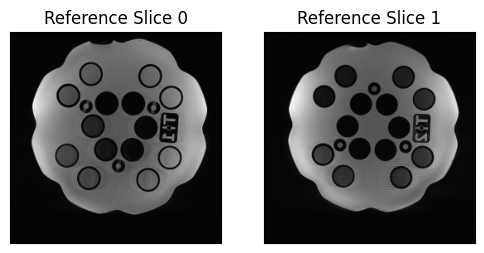

In [4]:
# Load in all data (keep on cpu until it is needed)

# Initialize data arrays
calib_data = []
accel_data = []
ref_images = []

# Loops over SMS factors
for sms in sms_factors:

    # Gets the calibration datapath for each SMS factor
    calibfile = os.path.join(sms_folder, 'SMS_%i'%(sms), 'ksp_calib.h5')

    # Load the calibration data from the filepath
    with h5py.File(calibfile,'r') as F:
        ksp_calib = torch.tensor(np.array(F['ksp'][...,0], dtype=np.complex64), dtype=torch.complex64, device=torch.device('cpu'))

    # Gets the frequency encode array size
    N = ksp_calib.shape[0]

    # # Used for showing coil compressed reference images
    # # Comment in to look at reference images with coil compression
    # # DO NOT run the reconstructions with these lines commented in and coil compression on
    # if coil_compression:
        
    #     # Modifies the kspace to be compatible with CoilCompress class
    #     ksp_calib = ksp_calib.permute(2,0,1)
    #     ksp_calib = ksp_calib.unsqueeze(0)

    #     # Computes the coil compression
    #     coilCompress = CoilCompress(ksp_calib,ncoils)

    #     # Applies the coil compression
    #     ksp_calib = coilCompress.compress(ksp_calib)

    #     # Reverts the kspace to the same shape as before coil compression
    #     ksp_calib = ksp_calib.squeeze(0)
    #     ksp_calib = ksp_calib.permute(1,2,0)

    # Final matrix size is square, matching that of the frequency encode array size
    final_matrix_size = (N,N)

    # Shift POMP FOVs for even SMS factors
    if sms%2 == 0:
        phi = 2 * np.pi / (2 * sms)
        for p in range(2*sms):
            ksp_calib[:,p::(2*sms),:] = ksp_calib[:,p::(2*sms),:] * np.exp(-1j * p * phi)

    # Bring to extended phase FOV (POMP) image space 
    img = ifft2d(ksp_calib, dims=(0,1))

    # Shifts the image so slices furthest from isocenter appear first and slice at isocenter appears last
    isocenter_slice = sms//2
    nshift = (sms - isocenter_slice - 1) * N 
    img = torch.roll(img, shifts=nshift, dims=1) 

    # Extract each slice from the extended POMP FOV
    img = torch.stack([img[:,(n*N):((n+1)*N),:] for n in range(sms)], axis=-1)

    # Flip so that slice position increases with index 
    img = torch.flip(img, dims=(-1,))

    # Shows the reference images
    rss = torch.sqrt(torch.sum(torch.abs(img * img.conj()),dim=2))
    fig, ax = plt.subplots(1,sms)
    fig.set_figwidth(3*sms)
    for n in range(sms):
        ax[n].imshow(rss[:,:,n].cpu(), cmap='gray')
        ax[n].set_xticks([])
        ax[n].set_yticks([])
        ax[n].set_title('Reference Slice %i'%(n))
    plt.show()

    # Brings the data back to k-space
    data = fft2d(img, dims=(0,1))

    # Add CAIPI shifts to calibration data 
    blip_phase_increment = 2 * np.pi / sms 
    for slc in range(sms):
        for p in range(sms):
            data[:,p::sms,:,slc] = data[:,p::sms,:,slc] * np.exp(1j*blip_phase_increment*slc*p)

    # Re-arrange the data 
    data = data.permute(3,2,0,1)

    # Saves the fully sampled kspace as calibration_data
    calib_data.append(data.clone())

    # Saves the reference images as ref_images
    ref_images.append(img.clone())

    # Gets the SMS accelerated datapath
    accelfile = os.path.join(sms_folder, 'SMS_%i'%(sms), 'ksp_accel.h5')

    # Load the accelerated data from the filepath
    with h5py.File(accelfile,'r') as F:
        aliased_ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0]

    # Puts the aliased k-space onto the cpu
    aliased_ksp = torch.tensor(aliased_ksp, dtype=torch.complex64, device=torch.device('cpu'))

    # Rearranges kspace shape to work with functions
    aliased_ksp = aliased_ksp.permute(2,0,1)[None,...]

    # Saves the SMS accelerated kspace as accel_data
    accel_data.append(aliased_ksp.clone())

# Image Reconstruction

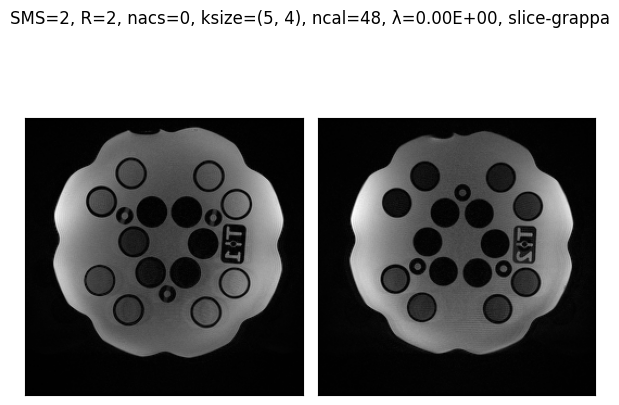

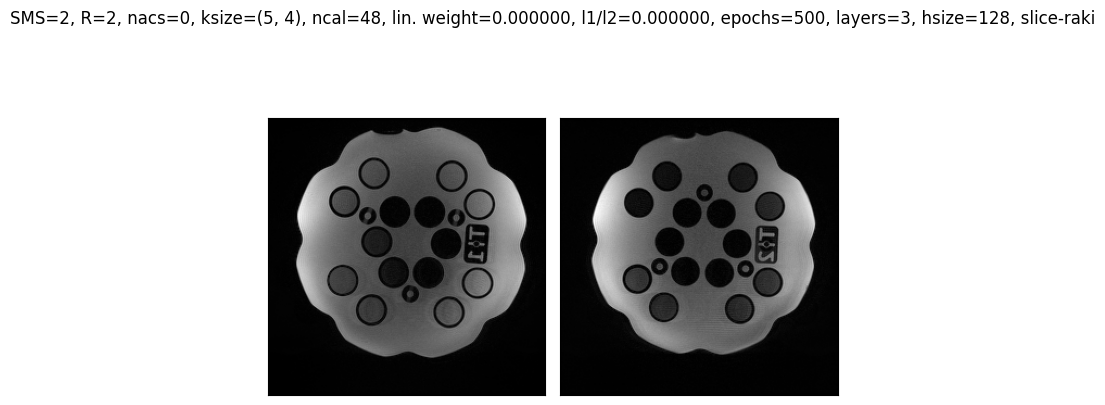

In [5]:
# Loops over all in plane acceleration factors
for rip in in_plane_acceleration_factors:

    # Loops over all number of calibration lines
    for ncal in num_calib_lines:

        # Loops over all combinations of entered kernel sizes
        for rks in readout_kernel_size:
            for pks in phase_kernel_size:

                # Loops over all SMS factors
                for sms in sms_factors:

                    # Transfer calibration data to GPU-accelerated device for current SMS factor
                    data_cal = calib_data[sms_factors.index(sms)].clone().to(device)

                    # Compresses the coil count to ncoils (from 32), if desired
                    if coil_compression:
                        data_cal_tmp = torch.sum(data_cal, dim=0, keepdim=True)
                        coilCompress = CoilCompress(data_cal_tmp,ncoils)
                        data_cal = coilCompress.compress(data_cal)

                    # Crop the calibration data to be the desired number of calibration lines
                    i1 = int(data_cal.shape[-1]/2 - ncal/2)
                    i2 = i1 + ncal 
                    data_cal = data_cal[...,i1:i2]

                    # Sets the acceleration for GRAPPA/RAKI functions to use
                    accel = (1, rip)
                    
                    #################
                    # GRAPPA recons #
                    #################

                    # Loops over all GRAPPA recon types
                    for recon_name in grappa_recon_types:

                        # Loops over all GRAPPA-specific parameters 

                        # Loops over all entered Tikhonov regularization values
                        for tik in tik_values:

                            # Determines the best kernel size depending on the current algorithm and then calibrates for the algorithm
                            if recon_name == 'sense-grappa':
                                kernel_size = (2*(rks//2), pks if rip == 1 else 2*(pks//2))
                                obj = sense_grappa(data_cal, accel=accel, kernel_size=kernel_size, tik=tik, final_matrix_size=final_matrix_size)
                            elif recon_name == 'slice-grappa':
                                kernel_size = (rks, pks if rip == 1 else 2*(pks//2))
                                obj = slice_grappa(data_cal, accel=accel, kernel_size=kernel_size, tik=tik, final_matrix_size=final_matrix_size)
                            elif recon_name == 'split-slice-grappa':
                                kernel_size = (rks, pks if rip == 1 else 2*(pks//2))
                                obj = split_slice_grappa(data_cal, accel=accel, kernel_size=kernel_size, tik=tik, final_matrix_size=final_matrix_size)

                            # Loops over all other reconstruction parameters

                            # Loops over number of ACS lines
                            for nacs in in_plane_acs_sizes:

                                # Transfer accelerated data to device for current SMS factor
                                data_acc = accel_data[sms_factors.index(sms)].clone().to(device)

                                # Compresses the coil count to ncoils, (from 32) if desired
                                if coil_compression == True:
                                    data_acc = coilCompress.compress(data_acc)

                                # Get the ACS data
                                if nacs > 0:
                                    i1 = int(aliased_ksp.shape[-1]/2 - nacs/2)
                                    i2 = i1 + nacs 
                                    acs_data = data_acc[...,i1:i2].clone()

                                # Retrospective in-plane acceleration
                                for n in range(1,rip):
                                    data_acc[...,n::rip] = 0.0

                                # Put central ACS lines back into array
                                if nacs > 0:
                                    data_acc[...,i1:i2] = acs_data 

                                # Applies the reconstruction!
                                ksp_recon, _ = obj.apply(data_acc)

                                # Frees up GPU memory
                                if len(in_plane_acs_sizes)==1:
                                    del obj

                                # Remove CAIPI shifts from reconstructed data
                                blip_phase_increment = 2 * np.pi / sms 
                                for slc in range(sms):
                                    for p in range(sms):
                                        ksp_recon[slc,:,:,p::sms] = ksp_recon[slc,:,:,p::sms] * np.exp(-1j*blip_phase_increment*slc*p) # [slice, coil, kx, ky]
                                
                                # Brings the data into the image domain
                                img_recon = ifft2d(ksp_recon, dims=(2,3))
                                img_recon = torch.sqrt(torch.sum(torch.abs(img_recon * img_recon.conj()), dim=1))

                                # Plots the GRAPPA reconstructions
                                fig, ax = plt.subplots(1,sms)
                                fig.set_figwidth(3*sms)
                                for n in range(sms):
                                    ax[n].imshow(img_recon[n,:,:].cpu(), cmap='gray')
                                    ax[n].set_xticks([])
                                    ax[n].set_yticks([])
                                fig.suptitle('SMS=%i, R=%i, nacs=%i, ksize=%s, ncal=%i, λ=%.2E, %s'%(sms, rip, nacs, kernel_size, ncal, tik, recon_name))
                                fig.tight_layout()
                                plt.show()

                                # Breaks out of the ACS loop if there is multiple ACS values for in-plane acceleration of 1 to save time
                                if rip == 1: break

                    ########################
                    # RAKI reconstructions #
                    ########################
                                
                    # Loops over all RAKI recon types
                    for recon_name in raki_recon_types:

                        # Loops over all RAKI-secpific parameters

                        # Loops over all desired values of linear weight(residual RAKI)
                        for linear_weight in linear_weights:

                            # Loops over all desired values of epochs
                            for epochs in num_epochs:

                                # Loops over all desired values of number of neural network layers
                                for nlayers in num_layers:

                                    # Loops over all desired values of neurons per layer
                                    for hsize in hidden_sizes:

                                        # Loops over all desired values of training / validation splits
                                        for train_split in train_splits:

                                            # Loops over all desired L1/L2 regularization values
                                            for l2_frac in l1_l2_tradeoff_values:

                                                # Loops over all desired network types
                                                for net_type in net_types:

                                                    # Loops over all other reconstruction parameters

                                                    # Loops over number of ACS lines  
                                                    for nacs in in_plane_acs_sizes:

                                                        # Determines the best kernel size depending on the current algorithm and then conducts the neural network training
                                                        if recon_name == 'sense-raki':
                                                            kernel_size = (2*(rks//2), pks if rip == 1 else 2*(pks//2))
                                                            obj = sense_raki(data_cal, raki_recon_folder, accel=accel, kernel_size=kernel_size, final_matrix_size=final_matrix_size,
                                                                                linear_weight=linear_weight, num_epochs=epochs, num_layers=nlayers, hidden_size=hsize, train_split=train_split,
                                                                                loss_function='L1_L2', l2_frac=l2_frac, net_type=net_type)
                                                        elif recon_name == 'slice-raki':
                                                            kernel_size = (rks, pks if rip == 1 else 2*(pks//2))
                                                            obj = slice_raki(data_cal, raki_recon_folder, accel=accel, kernel_size=kernel_size, final_matrix_size=final_matrix_size,
                                                                                linear_weight=linear_weight, num_epochs=epochs, num_layers=nlayers, hidden_size=hsize, train_split=train_split,
                                                                                loss_function='L1_L2', l2_frac=l2_frac, net_type=net_type)
                                                        elif recon_name == 'split-slice-raki':
                                                            kernel_size = (rks, pks if rip == 1 else 2*(pks//2))
                                                            obj = split_slice_raki(data_cal, raki_recon_folder, accel=accel, kernel_size=kernel_size, final_matrix_size=final_matrix_size,
                                                                                linear_weight=linear_weight, num_epochs=epochs, num_layers=nlayers, hidden_size=hsize, train_split=train_split,
                                                                                loss_function='L1_L2', l2_frac=l2_frac, net_type=net_type)

                                                        # Transfer accelerated data to device for current SMS factor
                                                        data_acc = accel_data[sms_factors.index(sms)].clone().to(device)

                                                        # Compresses the coil count to ncoils, (from 32) if desired
                                                        if coil_compression == True:
                                                            data_acc = coilCompress.compress(data_acc)

                                                        # Get the ACS data
                                                        if nacs > 0:
                                                            i1 = int(aliased_ksp.shape[-1]/2 - nacs/2)
                                                            i2 = i1 + nacs 
                                                            acs_data = data_acc[...,i1:i2].clone()

                                                        # Retrospective in-plane acceleration
                                                        for n in range(1,rip):
                                                            data_acc[...,n::rip] = 0.0

                                                        # Put central ACS lines back into array
                                                        if nacs > 0:
                                                            data_acc[...,i1:i2] = acs_data 

                                                        # Applies the reconstruction!
                                                        ksp_recon, _ = obj.apply(data_acc)

                                                        # Frees up GPU memory
                                                        if len(in_plane_acs_sizes)==1:
                                                            del obj

                                                        # Remove CAIPI shifts from reconstructed data
                                                        blip_phase_increment = 2 * np.pi / sms 
                                                        for slc in range(sms):
                                                            for p in range(sms):
                                                                ksp_recon[slc,:,:,p::sms] = ksp_recon[slc,:,:,p::sms] * np.exp(-1j*blip_phase_increment*slc*p)
                                                        
                                                        # Brings the data into the image domain
                                                        img_recon = ifft2d(ksp_recon, dims=(2,3))
                                                        img_recon = torch.sqrt(torch.sum(torch.abs(img_recon * img_recon.conj()), dim=1))

                                                        # Plots the RAKI reconstructions
                                                        fig, ax = plt.subplots(1,sms)
                                                        fig.set_figwidth(3*sms)
                                                        for n in range(sms):
                                                            ax[n].imshow(img_recon[n,:,:].cpu(), cmap='gray')
                                                            ax[n].set_xticks([])
                                                            ax[n].set_yticks([])
                                                        fig.suptitle('SMS=%i, R=%i, nacs=%i, ksize=%s, ncal=%i, lin. weight=%f, l1/l2=%f, epochs=%i, layers=%i, hsize=%i, %s' % \
                                                                    (sms, rip, nacs, kernel_size, ncal, linear_weight, l2_frac, epochs, nlayers, hsize, recon_name))
                                                        fig.tight_layout()
                                                        plt.show()

                                                        # Breaks out of the ACS loop if there is multiple ACS values for in-plane acceleration of 1 to save time
                                                        if rip == 1: break